# **Swarm Robotics Competitions**

### 2021/2022      

## A. Pedro Aguiar
<pedro.aguiar@fe.up.pt>
<br>

<br> FEUP Nov. 2021


# Competition Swarm Robotics



### **A swarm of 5 agents with a leader agent** steering to resource $R_1$


Consider a fleet of n=5 agents (robots), and let agent 1 be the leader.

Consider also that:
- leader 1 has access to its position $\xi_1$
- all the other agents only have access to the relative position with respect to the other agents, that is, $\xi_{ij}=\xi_i-\xi_j$.  This is only true if they are close to each other (maximum range of 2m), otherwise they are considered lost and you are unable to control them. To regain control you need to get within 2m of the lost drone.
- all the agents have access to the closest distance and angle (direction) of the nearest obstacle, that is, $d_{io}$ and $\theta_{io}$.

**Goal:** Reach the resource $R_1$ with at least 2 agents and carry the resource to the base (The base has a green border in the plot).

- if the agents carrying food get more than 1.5m appart, the food will drop in its initial position. The same thing will happen if one (or both) of the drones carrying the food collides with another drone or a wall.
- if the leader is destroyed, you loose control of all drones.
- each pair of drones can only carry one type of food, i.e. if drone 2 is carying food 1 with drone x, drone 2 will be unable to carry food 2 with any other drone.
- 4 times are considered for scores. The times of catching food 1 and 2, and the times of dropping the food at base. If the drones drop the food, the time will be reset. 

**Solution:** From the notebook "*Motion control of a single agent*", one option is to assign to agent 1 (leader) the feedback control law

$$
u_1 = - K_1 (\xi_1-\xi_d) + \frac{k_{1o}(d_{1o})}{d_{1o}^2} ( \xi_1 - \xi_o ) + \dot{\xi}_d, \quad
k_{1o}(d_{1o}) = \bar k_{1o}e^{-c d_{1o}^2},
$$

where
$K_1, k_{1o}, c$ are positive gains, $d_{1o}$ is the range to the nearest obstacle, $\xi_o$ is the center of the obstacle, and 

$$
\xi_d = R_1, \quad \dot\xi_d = 0
$$







Note that the above law cannot be implementable because we don't know $\xi_0$ !

But we can consider $\xi_0$ to be the closest point of the obstacle to the agent. In that case, we get $\xi_0= \xi_1+[d_{1o}\cos\theta_{1o}, d_{1o}\sin\theta_{1o}]^T$, and therefore, the control law simplifies to

$$
u_1 = - K_1 (\xi_1-\xi_d) - \frac{k_{1o}(d_{1o})}{d_{1o}} 
\left[
\begin{array}{c}
\cos\theta_{1o} \\
\sin\theta_{1o}
\end{array}
\right]
$$
where $d_{1o}$ and $\theta_{1o}$ is the range and angle of agent $i$ to the nearest obstacle.

To make sure that the other agents follow the leader, we set 

$$
u_i = - K_i \sum_{j\in N_i}\big(\xi_{ij} -b_{ij}\big) + \sum_{j= 1}^n \frac{k_{ij}(d_{ij})}{d_{ij}^2}  \xi_{ij} - \frac{k_{io}(d_{io})}{d_{io}} 
\left[
\begin{array}{c}
\cos\theta_{io} \\
\sin\theta_{io}
\end{array}
\right]
+
\dot \xi_d, \quad i=2, 3,\ldots n
$$

$$
d_{ij} = ||\xi_{ij}||, \quad
%d_{io} = ||\xi_i - \xi_o ||
$$



where $K_i$ is a $2\times 2$ positive-definite matrix gain, and the bias terms $b_{ij}= -b_{ji}$ specifies the formation configuration.



In [1]:
import math
import numpy as np
from dynamic_systems import Integrator, Line, Ellipse, World, ConvexPolygon, check_collisions, proximity, closest_drones, food_base_check

# World arena
arena = ConvexPolygon([[ 10.0, -10.0 ],
                       [ 10.0, 10.0 ],
                       [ -10.0, 10.0 ],
                       [ -10.0, -10.0]])

# World obstacles
obs1 = Ellipse(center = [-1.0, -1.0], angle = np.radians(15.0), axes = [3.0, 1.5])

# Food
food = {1: [-5,4], 2:[0,0]}
num_foods = 1
dot_xid = (0,0)
looking_for = 0

# Base
x_base = (-7.5,-7.5)

# Define world
world = World(arena)
world.add_obstacle(obs1)

#######################
# Dynamics: States=[xi] Control=[u] where xi_dot=u
initial_state1 = [0.0, -8.0]
initial_control1 = [0.0, 0.0]
robot1 = Integrator(initial_state1, initial_control1)

initial_state2 = [0.5, -8.0]
initial_control2 = [0.0, 0.0]
robot2 = Integrator(initial_state2, initial_control2)

initial_state3 = [1.0, -8.0]
initial_control3 = [0.0, 0.0]
robot3 = Integrator(initial_state3, initial_control3)

initial_state4 = [1.5, -8.0]
initial_control4 = [0.0, 0.0]
robot4 = Integrator(initial_state4, initial_control4)

initial_state5 = [2.0, -8.0]
initial_control5 = [0.0, 0.0]
robot5 = Integrator(initial_state5, initial_control5)

dt = 0.1
sim_time = 100
time = []
ux1, uy1 = [], []
x1, y1 = [], []
ux2, uy2 = [], []
x2, y2 = [], []
ux3, uy3 = [], []
x3, y3 = [], []
ux4, uy4 = [], []
x4, y4 = [], []
ux5, uy5 = [], []
x5, y5 = [], []
xdv, ydv = [], []

distance41 = []
distance21 = []
distance31 = []
distance51 = []

cpx1, cpy1 = [], []
cpx2, cpy2 = [], []
cpx3, cpy3 = [], []
cpx4, cpy4 = [], []
cpx5, cpy5 = [], []

R1 = np.array([5, 5])
do = np.zeros((5)) # Distance to obstacle


# Matrices 
c_mtx = np.zeros((5)) # Collision matrix
d_mtx = np.zeros((5)) # Damaged matrix
l_mtx = np.zeros((5)) # Lost matrix
food_delivered = np.zeros((2)) # Delivered food
w_food_mtx = np.zeros((5)) # Matrix that tells if a pair of drones cought some food
time_score = np.array([999,999,999,999]) # 0 - caught food 1, 1 - caught food 2, 2 - left food 1 in base, 3 - left food 2 in base

In [2]:
###################################################################################################
##                                                                                               ##
##                              Section of values that you can tune                              ##
##                                                                                               ##
###################################################################################################

# !! Gain matrix !!
kx, ky = 1, 1 
K = np.diag([kx,ky])

# !! k_ij, k_io, c gains !!
#Kio = np.diag([kx,ky])
#kij = np.diag([kx,ky])
#c = ...             


# !! Bias values !!
# b12 = [x,y]...


###################################################################################################
##                                                                                               ##
##                                         End of section                                        ##
##                                                                                               ##
###################################################################################################



for t in np.linspace(0.0, sim_time, num=int(sim_time/dt)):

    # Time
    time.append(t)

    # Get the state
    state1 = robot1.get_state()
    state2 = robot2.get_state()
    state3 = robot3.get_state()
    state4 = robot4.get_state()
    state5 = robot5.get_state()
    
    # Relative positions
    xi21 = state2 - state1  
    xi31 = state3 - state1    
    xi41 = state4 - state1    
    xi51 = state5 - state1   


###################################################################################################
##                                                                                               ##
##                                      Your code goes here                                      ##
##                                                                                               ##
###################################################################################################
    
    # Control law
    # Drone 1 - Leader
    closest_pt, do[0] = world.compute_closest(state1) # closest point and distance to that point
    angle = np.arctan2(closest_pt[1]-state1[1],closest_pt[0]-state1[0])
    cpx1.append(closest_pt[0])
    cpy1.append(closest_pt[1])
    # u_control1 = ...


    # Drone 2 
    closest_pt, do[1] = world.compute_closest(state2)
    angle = np.arctan2(closest_pt[1]-state2[1],closest_pt[0]-state2[0])
    cpx2.append(closest_pt[0])
    cpy2.append(closest_pt[1])
    # u_control2 = ...


    # Drone 3
    closest_pt, do[2] = world.compute_closest(state3)
    angle = np.arctan2(closest_pt[1]-state3[1],closest_pt[0]-state3[0])
    cpx3.append(closest_pt[0])
    cpy3.append(closest_pt[1])
    # u_control3 = ... 


    # Drone 4
    closest_pt, do[3] = world.compute_closest(state4)
    angle = np.arctan2(closest_pt[1]-state4[1],closest_pt[0]-state4[0])
    cpx4.append(closest_pt[0])
    cpy4.append(closest_pt[1])
    # u_control4 = ... 
    

    # Drone 5
    closest_pt, do[4] = world.compute_closest(state5)
    angle = np.arctan2(closest_pt[1]-state5[1],closest_pt[0]-state5[0])
    cpx5.append(closest_pt[0])
    cpy5.append(closest_pt[1])
    # u_control5 = ...

    # !! Delete these to be able to control the drones !!
    u_control1 = (0,0)
    u_control2 = (0,0)
    u_control3 = (0,0)
    u_control4 = (0,0)
    u_control5 = (0,0)

###################################################################################################
##                                                                                               ##
##                              End of code section, don edit this part                          ##
##                                                                                               ##
###################################################################################################


    xi = (xi21, xi31, xi41, xi51)
    points_vec = np.array([state1,state2,state3,state4,state5])

    # Collision check between drones
    l_mtx, d_mtx, w_food_mtx, time_score = check_collisions(points_vec, l_mtx, d_mtx, w_food_mtx, do, xi, time_score)
    prox_mtx_1, prox_mtx_2 = proximity(points_vec, food, num_foods)

    # Send actuation commands
    if d_mtx[0]==1:
        u_control1=[0,0]
        u_control2=[0,0]
        u_control3=[0,0]
        u_control4=[0,0]
        u_control5=[0,0]
        prox_mtx_1[0] = 99
        prox_mtx_2[0] = 99    
        prox_mtx_1[1] = 99
        prox_mtx_2[1] = 99        
        prox_mtx_1[2] = 99
        prox_mtx_2[2] = 99        
        prox_mtx_1[3] = 99
        prox_mtx_2[3] = 99        
        prox_mtx_1[4] = 99
        prox_mtx_2[4] = 99        

    if d_mtx[1]==1 or l_mtx[1]==1:
        u_control2=[0,0]
        prox_mtx_1[1] = 99
        prox_mtx_2[1] = 99

    if d_mtx[2]==1 or l_mtx[2]==1:
        u_control3=[0,0]
        prox_mtx_1[2] = 99
        prox_mtx_2[2] = 99

    if d_mtx[3]==1 or l_mtx[3]==1:
        u_control4=[0,0]
        prox_mtx_1[3] = 99
        prox_mtx_2[3] = 99

    if d_mtx[4]==1 or l_mtx[4]==1:
        u_control5=[0,0]
        prox_mtx_1[4] = 99
        prox_mtx_2[4] = 99

    
    # Find the closest drones to the food
    w_food_mtx, time_score = closest_drones(prox_mtx_1, prox_mtx_2, w_food_mtx, time_score, t, food_delivered, looking_for, num_foods)
    
    u_control1 = np.clip(u_control1, -1, 1)
    u_control2 = np.clip(u_control2, -1, 1)
    u_control3 = np.clip(u_control3, -1, 1)
    u_control4 = np.clip(u_control4, -1, 1)
    u_control5 = np.clip(u_control5, -1, 1)

    robot1.set_control(u_control1)
    robot1.actuate(dt)
    robot2.set_control(u_control2)
    robot2.actuate(dt)
    robot3.set_control(u_control3)
    robot3.actuate(dt)
    robot4.set_control(u_control4)
    robot4.actuate(dt)
    robot5.set_control(u_control5)
    robot5.actuate(dt)    

    
    ux1.append(u_control1[0])
    uy1.append(u_control1[1])
    x1.append(state1[0])
    y1.append(state1[1])
    ux2.append(u_control2[0])
    uy2.append(u_control2[1])
    x2.append(state2[0])
    y2.append(state2[1])
    ux3.append(u_control3[0])
    uy3.append(u_control3[1])
    x3.append(state3[0])
    y3.append(state3[1])
    ux4.append(u_control4[0])
    uy4.append(u_control4[1])
    x4.append(state4[0])
    y4.append(state4[1])
    ux5.append(u_control5[0])
    uy5.append(u_control5[1])
    x5.append(state5[0])
    y5.append(state5[1])

    distance41.append(np.sqrt(xi41[0]**2 + xi41[1]**2))
    distance21.append(np.sqrt(xi21[0]**2 + xi21[1]**2))
    distance31.append(np.sqrt(xi31[0]**2 + xi31[1]**2))
    distance51.append(np.sqrt(xi51[0]**2 + xi51[1]**2))

    w_food_mtx, time_score, food_delivered = food_base_check(w_food_mtx, points_vec, food, time_score, t, food_delivered)

/home/joaocsa/.local/lib/python3.8/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Results:


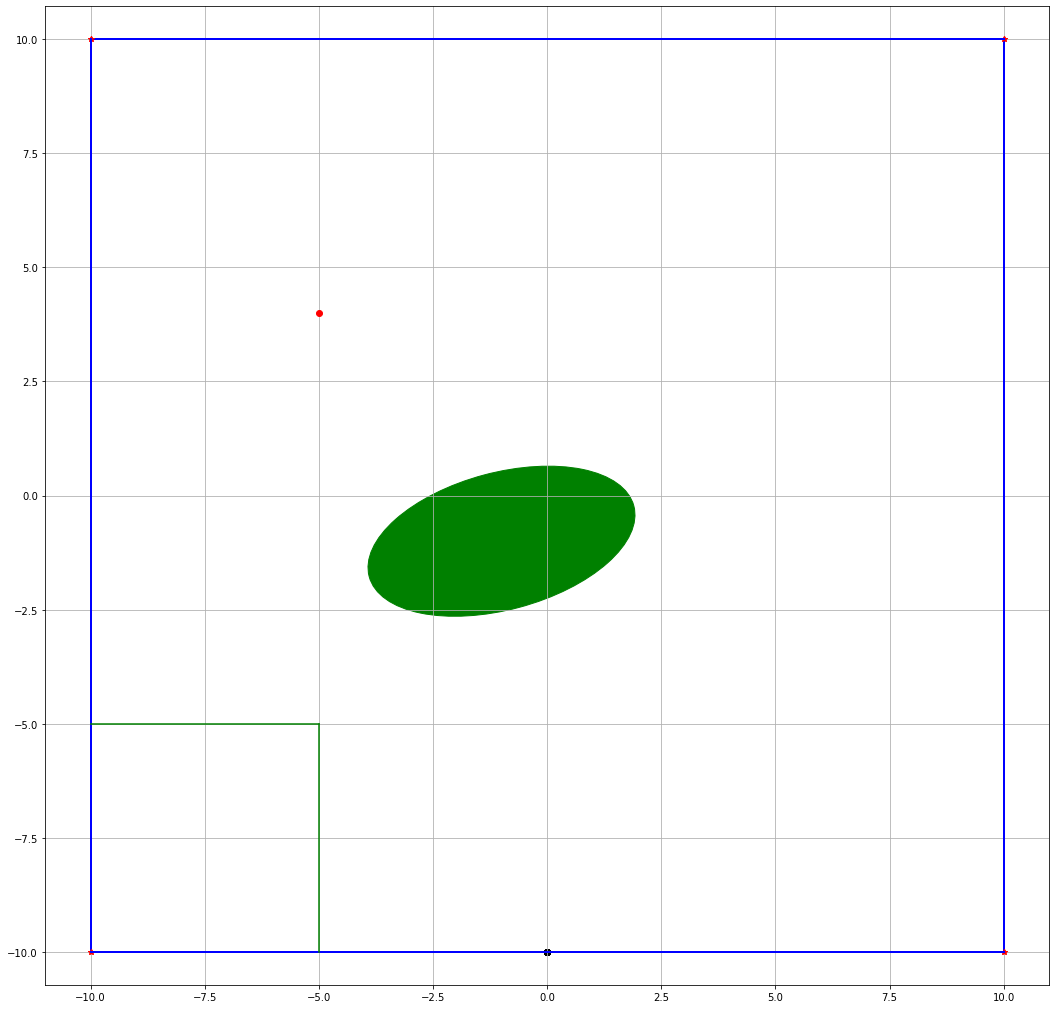

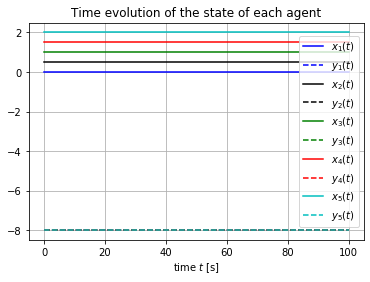

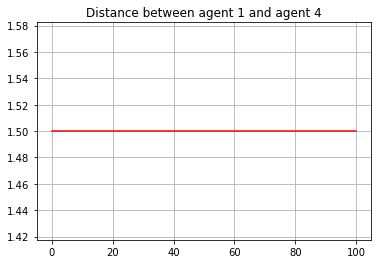

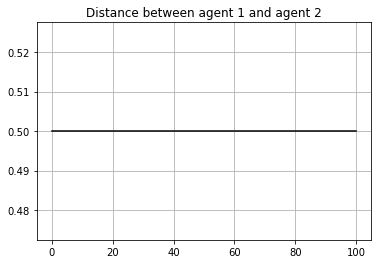

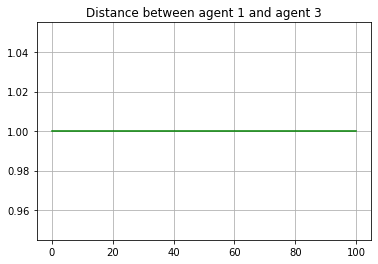

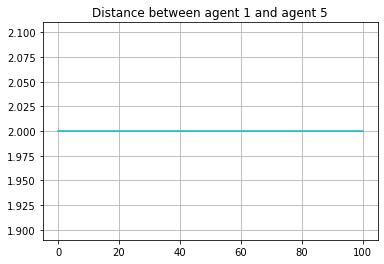

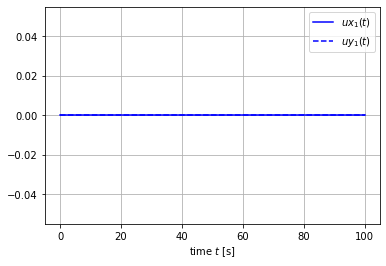

In [3]:
# Plot commands
%matplotlib inline 
#%matplotlib notebook

import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(18,18))

#plt.figure(figsize=(1,1))
ax.axis('equal')
xdim, ydim = 10, 10
plt.xlim(-xdim-1,xdim+1)
plt.ylim(-ydim-1,ydim+1)
plt.grid()


# Plots walls and obstacles
world.plot()

plt.plot(x1, y1, label='$x_1(t), y_1(t)$', color='b')
plt.scatter(cpx1, cpy1, label='$cpx_1(t), cpy_1(t)$', marker='o', color='k')
plt.plot(x2, y2, label='$x_2(t), y_2(t)$', color='k')
plt.plot(x3, y3, label='$x_3(t), y_3(t)$', color='g')
plt.plot(x4, y4, label='$x_4(t), y_4(t)$', color='r')
plt.plot(x5, y5, label='$x_5(t), y_5(t)$', color='c')
plt.plot((-10,-5),(-5,-5), color='g')
plt.plot((-5,-5),(-5,-10), color='g')
plt.plot(food[1][0], food[1][1], marker='o', color='r')
if num_foods == 2:
    plt.plot(food[2][0], food[2][1], marker='o', color='g')
if d_mtx[0] == 1:
    plt.plot(state1[0], state1[1], marker='*', color='y')
if d_mtx[1] == 1:
    plt.plot(state2[0], state2[1], marker='*', color='y')
if d_mtx[2] == 1:
    plt.plot(state3[0], state3[1], marker='*', color='y')
if d_mtx[3] == 1:
    plt.plot(state4[0], state4[1], marker='*', color='y')
if d_mtx[4] == 1:
    plt.plot(state5[0], state5[1], marker='*', color='y')


plt.figure()
plt.plot(time, x1, label='$x_1(t)$', color='b')
plt.plot(time, y1, label='$y_1(t)$', color='b', linestyle='dashed')
plt.plot(time, x2, label='$x_2(t)$', color='k')
plt.plot(time, y2, label='$y_2(t)$', color='k', linestyle='dashed')
plt.plot(time, x3, label='$x_3(t)$', color='g')
plt.plot(time, y3, label='$y_3(t)$', color='g', linestyle='dashed')
plt.plot(time, x4, label='$x_4(t)$', color='r')
plt.plot(time, y4, label='$y_4(t)$', color='r', linestyle='dashed')
plt.plot(time, x5, label='$x_5(t)$', color='c')
plt.plot(time, y5, label='$y_5(t)$', color='c', linestyle='dashed')

plt.xlabel('time $t$ [s]')
plt.legend()
plt.grid()
plt.title('Time evolution of the state of each agent');

plt.figure()
plt.plot(time, distance41, label='$x_1(t)$', color='r')
plt.grid()
plt.title('Distance between agent 1 and agent 4');

plt.figure()
plt.plot(time, distance21, label='$x_1(t)$', color='k')
plt.grid()
plt.title('Distance between agent 1 and agent 2');

plt.figure()
plt.plot(time, distance31, label='$x_1(t)$', color='g')
plt.grid()
plt.title('Distance between agent 1 and agent 3');

plt.figure()
plt.plot(time, distance51, label='$x_1(t)$', color='c')
plt.grid()
plt.title('Distance between agent 1 and agent 5');

plt.figure()
plt.plot(time, ux1, label='$ux_1(t)$', color='b')
plt.plot(time, uy1, label='$uy_1(t)$', color='b', linestyle='dashed')
plt.xlabel('time $t$ [s]')
plt.legend()
plt.grid()

print("Results:")